* Ini dibuat sebelum merubah konsep app yang akan terus ngeretrain model


# Install / Import 

In [1]:
import sys
print(sys.executable)

/usr/local/bin/python3


In [2]:
#pip install torch torchvision torchaudio

In [3]:
#import torch

In [4]:
#pip install keras

In [5]:
#pip install tensorflow

In [ ]:
#import keras

2025-05-20 13:49:49.178001: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/ray/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
  

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/ray/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/ray/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/ray/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File 

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/ray/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/ray/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/ray/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File 

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

In [6]:
#pip install pandas numpy matplotlib scikit-learn 

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from sklearn.preprocessing import MinMaxScaler


# Load Dataset

In [36]:
df = pd.read_csv('../Dataset/Historical/HistoricalData.csv')


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430 entries, 0 to 5429
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5430 non-null   int64  
 1   date        5430 non-null   object 
 2   price       5430 non-null   float64
 3   open        5430 non-null   float64
 4   high        5430 non-null   float64
 5   low         5430 non-null   float64
 6   volume      5430 non-null   float64
 7   change      5430 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 339.5+ KB


# preprocessing

In [38]:
 # Create features for prediction and avoid to modifying original data
df_processed = df.copy()
        
 # Adding technical indicators
df_processed['price_ma_7'] = df_processed['price'].rolling(window=7).mean() # -> 7-day moving average
df_processed['price_ma_30'] = df_processed['price'].rolling(window=30).mean() # -> 30-day moving average
df_processed['volatility'] = df_processed['price'].rolling(window=7).std() # -> 7-day rolling standard deviation
df_processed['volume_ma'] = df_processed['volume'].rolling(window=7).mean() # -> 7-day moving average of volume

# Create target variable (next day price)
df_processed['target'] = df_processed['price'].shift(-1) #  <-- Predicting next day's price

df_processed = df_processed.dropna()

feature_columns = ['price', 'open', 'high', 'low', 'volume', 'change', 
                  'price_ma_7', 'price_ma_30', 'volatility', 'volume_ma']

X = df_processed[feature_columns]
y = df_processed['target']
        
        
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#  Training Model Regression (Linear Regression & Random Forest)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, shuffle=False
)

In [ ]:
# Model 1: Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Model 2: Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train) 

RandomForestRegressor(random_state=42)

In [54]:
def eval_model(model, X, y, name):
    pred = model.predict(X)
    print(f"\n=== {name} ===")
    print("MAE :", mean_absolute_error(y, pred))
    print("RMSE:", np.sqrt(mean_squared_error(y, pred)))
    print("R²  :", r2_score(y, pred))

eval_model(linreg, X_test, y_test, "Linear Regression")
eval_model(rf_reg, X_test, y_test, "Random Forest Regressor")



=== Linear Regression ===
MAE : 910.2309543762158
RMSE: 1471.472632634483
R²  : 0.9972282545610707

=== Random Forest Regressor ===
MAE : 7179.885236111107
RMSE: 14334.858898596443
R²  : 0.7369515131252293


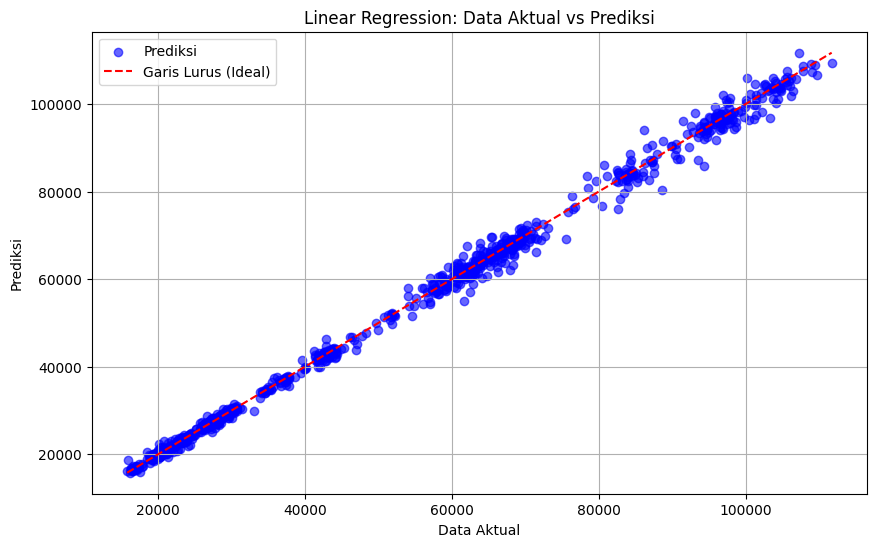

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Prediksi menggunakan Linear Regression
y_pred = linreg.predict(X_test)

# Plot data aktual vs prediksi
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Prediksi', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Garis Lurus (Ideal)', linestyle='--')

# Tambahkan label dan judul
plt.xlabel("Data Aktual")
plt.ylabel("Prediksi")
plt.title("Linear Regression: Data Aktual vs Prediksi")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Save model dan scaler
with open('../Model/price_prediction/linreg_model.pkl', 'wb') as f:
    pickle.dump(linreg, f)

with open('../Model/price_prediction/rf_reg_model.pkl', 'wb') as f:
    pickle.dump(rf_reg, f)

with open('../Model/price_prediction/scaler_price.pkl', 'wb') as f:
    pickle.dump(scaler, f)
